# Imports

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tabulate import tabulate

# Configs

In [76]:
LABELED_PATH = "../data/results/labels.parquet"
PREDICTED_XGB_PATH = "../data/results/xgb_prediction_labeled.parquet"
PREDICTED_XGB_ARIMA_PATH = "../data/results/xgb_predictions_tuned.parquet"
PREDICTED_REGRESSION_PATH = "../data/results/ridge_predictions.parquet"
PREDICTED_ARIMA_PATH = "../data/results/arima_predict.parquet"
TEST_START_DATE = '2023-04-01'
HIGH_DEMAND_NUMS = 50
MID_DEMAND_NUMS = 100
SAVE_PLOT_PATH = '../data/pngs/'
warnings.filterwarnings('ignore')

In [10]:
report_dict = {
    'high_demand_locations':{
        'MAPE':{
            'baseline_last_week':None,
            'model_regression':None,
            'model_xgboost':None
        },
        'MAE':{
            'baseline_last_week':None,
            'model_regression':None,
            'model_xgboost':None
        },
        'RMSE':{
            'baseline_last_week':None,
            'model_regression':None,
            'model_xgboost':None
        }
        
    },
    'mid_demand_locations':{
        'MAPE':{
            'baseline_last_week':None,
            'model_regression':None,
            'model_xgboost':None
        },
        'MAE':{
            'baseline_last_week':None,
            'model_regression':None,
            'model_xgboost':None
        },
        'RMSE':{
            'baseline_last_week':None,
            'model_regression':None,
            'model_xgboost':None
        }
        
    },    
    'low_demand_locations':{
        'MAPE':{
            'baseline_last_week':None,
            'model_regression':None,
            'model_xgboost':None
        },
        'MAE':{
            'baseline_last_week':None,
            'model_regression':None,
            'model_xgboost':None
        },
        'RMSE':{
            'baseline_last_week':None,
            'model_regression':None,
            'model_xgboost':None
        }
        
    },
    'all_locations':{
        'MAPE':{
            'baseline_last_week':None,
            'model_regression':None,
            'model_xgboost':None
        },
        'MAE':{
            'baseline_last_week':None,
            'model_regression':None,
            'model_xgboost':None
        },
        'RMSE':{
            'baseline_last_week':None,
            'model_regression':None,
            'model_xgboost':None
        }
    },
    
    
}

In [11]:
predictions_dict = {
    'baseline_last_day':None,
    'baseline_last_week':None,
    'model_regression':None,
    'model_xgboost':None,
}

In [12]:
sorted_locations_dict={
    'baseline_last_week':None,
    'model_regression':None,
    'model_xgboost':None,
}

In [13]:
predictions_mean_error_dict={
    
    'baseline_last_week':
    {
        'Location':
                {
                'high_demand_loc':None,
                'mid_demand_loc':None,
                'low_demand_loc':None,
                'all_loc':None
                },
        'Date':
                {
                'high_demand_loc':None,
                'mid_demand_loc':None,
                'low_demand_loc':None,
                'all_loc':None
                },
        'day_of_week':
                {
                'high_demand_loc':None,
                'mid_demand_loc':None,
                'low_demand_loc':None,
                'all_loc':None
                }
    },
    'model_regression':
    {
        'Location':
                {
                'high_demand_loc':None,
                'mid_demand_loc':None,
                'low_demand_loc':None,
                'all_loc':None
                },
        'Date':
                {
                'high_demand_loc':None,
                'mid_demand_loc':None,
                'low_demand_loc':None,
                'all_loc':None
                },
        'day_of_week':
                {
                'high_demand_loc':None,
                'mid_demand_loc':None,
                'low_demand_loc':None,
                'all_loc':None
                }
    },
    'model_xgboost':
    {
        'Location':
                {
                'high_demand_loc':None,
                'mid_demand_loc':None,
                'low_demand_loc':None,
                'all_loc':None
                },
        'Date':
                {
                'high_demand_loc':None,
                'mid_demand_loc':None,
                'low_demand_loc':None,
                'all_loc':None
                },
        'day_of_week':
                {
                'high_demand_loc':None,
                'mid_demand_loc':None,
                'low_demand_loc':None,
                'all_loc':None
                }
    },
}

# Load Data

## Load labeled data

In [14]:
labeled_df = pd.read_parquet(LABELED_PATH)
print(labeled_df.shape)
labeled_df.head()

(31440, 3)


,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


In [15]:
test_df = labeled_df.loc[labeled_df['Date']>=TEST_START_DATE]
test_df = test_df.reset_index(drop = True)
test_df.head()

,Location,Date,Demand
0,1,2023-04-01,13.0
1,1,2023-04-02,17.0
2,1,2023-04-03,9.0
3,1,2023-04-04,12.0
4,1,2023-04-05,18.0


## Load Predicted Data

In [16]:
predictions_dict['model_xgboost'] = pd.read_parquet(PREDICTED_XGB_ARIMA_PATH)
predictions_dict['model_xgboost'].head()

,Location,Date,Predicted_demand
0,1,2023-04-01,16.912674
1,1,2023-04-02,18.158730
2,1,2023-04-03,11.263210
3,1,2023-04-04,11.029713
4,1,2023-04-05,11.032634


In [17]:
predictions_dict['model_regression'] = pd.read_parquet(PREDICTED_REGRESSION_PATH)
predictions_dict['model_regression'].head()

,Location,Date,Predicted_demand
0,1,2023-04-01,24.753056
1,1,2023-04-02,26.706262
2,1,2023-04-03,15.639358
3,1,2023-04-04,16.354262
4,1,2023-04-05,14.041562


### BaseLine Models

In [18]:
def baseline_predict(dataset, shift_val):
    predicted_demand = dataset.groupby(['Location'])['Demand'].shift(shift_val)
    predicted_data = pd.DataFrame(dataset[['Location', 'Date']])
    predicted_data['Predicted_demand'] = predicted_demand
    return predicted_data

In [19]:
predictions_dict['baseline_last_week'] = baseline_predict(test_df, 7)

### Join Predictions and Actual

In [20]:
def join_actual_predict(actual_df, predicted_df):
    actual_predicted_df = actual_df.copy()
    actual_predicted_df['Predicted_demand'] = predicted_df['Predicted_demand']
    actual_predicted_df = actual_predicted_df.dropna()
    actual_predicted_df['day_of_week'] = actual_predicted_df['Date'].dt.dayofweek
    return actual_predicted_df

In [21]:
predictions_dict['baseline_last_week'] = join_actual_predict(test_df,predictions_dict['baseline_last_week'])
predictions_dict['baseline_last_week'].head()

,Location,Date,Demand,Predicted_demand,day_of_week
7,1,2023-04-08,14.0,13.0,5
8,1,2023-04-09,18.0,17.0,6
9,1,2023-04-10,17.0,9.0,0
10,1,2023-04-11,14.0,12.0,1
11,1,2023-04-12,16.0,18.0,2


In [22]:
predictions_dict['model_regression'] = join_actual_predict(test_df,predictions_dict['model_regression'])
predictions_dict['model_regression'].head()

,Location,Date,Demand,Predicted_demand,day_of_week
0,1,2023-04-01,13.0,24.753056,5
1,1,2023-04-02,17.0,26.706262,6
2,1,2023-04-03,9.0,15.639358,0
3,1,2023-04-04,12.0,16.354262,1
4,1,2023-04-05,18.0,14.041562,2


In [23]:
predictions_dict['model_xgboost'] = join_actual_predict(test_df,predictions_dict['model_xgboost'])
predictions_dict['model_xgboost'].head()

,Location,Date,Demand,Predicted_demand,day_of_week
0,1,2023-04-01,13.0,16.912674,5
1,1,2023-04-02,17.0,18.158730,6
2,1,2023-04-03,9.0,11.263210,0
3,1,2023-04-04,12.0,11.029713,1
4,1,2023-04-05,18.0,11.032634,2


### Sort Locations by Demand

In [24]:
def sort_locations_on_demand(predictions_dict,sorted_locations_dict):
    for label,predictions_df in predictions_dict.items():
        if (predictions_df is not None):
            sorted_index = predictions_df.groupby('Location')['Demand'].aggregate(['sum']).sort_values('sum', ascending=False)
            sorted_index = sorted_index.reset_index()
            sorted_locations_dict[label] = sorted_index

In [25]:
sort_locations_on_demand(predictions_dict, sorted_locations_dict)
sorted_locations_dict['model_xgboost'].head()

,Location,sum
0,132,173355.0
1,237,153779.0
2,161,149098.0
3,236,138316.0
4,142,113448.0


# Mean error Calculation

### Error Columns

In [77]:
def calculate_error(actual_predicted_dict: dict):
    for label,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            actual_predicted_df['error'] = np.abs(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            actual_predicted_df['squared_error'] = np.square(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            actual_Demand_df = np.where(actual_predicted_df['Demand']==0, 1, actual_predicted_df['Demand'])
            actual_predicted_df['percentage_error'] = (
                actual_predicted_df['error']/actual_Demand_df
                )*100
            

In [78]:
calculate_error(predictions_dict)
predictions_dict['model_regression'].head()

,Location,Date,Demand,Predicted_demand,day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,13.0,24.753056,5,11.753056,138.134320,90.408121
1,1,2023-04-02,17.0,26.706262,6,9.706262,94.211528,57.095661
2,1,2023-04-03,9.0,15.639358,0,6.639358,44.081077,73.770646
3,1,2023-04-04,12.0,16.354262,1,4.354262,18.959601,36.285520
4,1,2023-04-05,18.0,14.041562,2,3.958438,15.669228,21.991320


### Aggregate Error Columns

In [79]:
def calculate_maen_error(actual_predicted_dict: dict, predictions_mean_dict: dict):
    per_columns=['Location', 'Date', 'day_of_week']
    for model,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            sorted_index = sorted_locations_dict[model]['Location']
            high_demand_actual_predicted_df = actual_predicted_df.loc[actual_predicted_df['Location'].isin(sorted_index[:HIGH_DEMAND_NUMS])]
            mid_demand_actual_predicted_df = actual_predicted_df.loc[actual_predicted_df['Location'].isin(sorted_index[HIGH_DEMAND_NUMS:HIGH_DEMAND_NUMS+MID_DEMAND_NUMS])]
            low_demand_actual_predicted_df = actual_predicted_df.loc[actual_predicted_df['Location'].isin(sorted_index[HIGH_DEMAND_NUMS+MID_DEMAND_NUMS:])]
            for per in per_columns:
                high_demand_error_df = high_demand_actual_predicted_df[[per,'Demand','error','squared_error', 'percentage_error',]] 
                mid_demand_error_df = mid_demand_actual_predicted_df[[per,'Demand','error','squared_error','percentage_error']] 
                low_demand_error_df = low_demand_actual_predicted_df[[per,'Demand','error','squared_error','percentage_error']] 
                all_error_df = actual_predicted_df[[per,'Demand','error','squared_error','percentage_error']]
                
                high_demand_mean_df = high_demand_error_df\
                                                .groupby(per)\
                                                .agg(mape=('percentage_error','mean'),
                                                    mae=('error','mean'),
                                                    mse=('squared_error','mean'),
                                                    demand_mean=('Demand','mean')) 
                mid_demand_mean_df = mid_demand_error_df\
                                                .groupby(per)\
                                                .agg(mape=('percentage_error','mean'),
                                                    mae=('error','mean'),
                                                    mse=('squared_error','mean'),
                                                    demand_mean=('Demand','mean'))
                low_demand_mean_df = low_demand_error_df\
                                                .groupby(per)\
                                                .agg(mape=('percentage_error','mean'),
                                                    mae=('error','mean'),
                                                    mse=('squared_error','mean'),
                                                    demand_mean=('Demand','mean')) 
                all_mean_df = all_error_df\
                                            .groupby(per)\
                                            .agg(mape=('percentage_error','mean'),
                                                mae=('error','mean'),
                                                mse=('squared_error','mean'),
                                                demand_mean=('Demand','mean')) 
                high_demand_mean_df['mape'] = np.where(high_demand_mean_df['mape']>100, 100, high_demand_mean_df['mape'])
                mid_demand_mean_df['mape'] = np.where(mid_demand_mean_df['mape']>100, 100, mid_demand_mean_df['mape'])
                low_demand_mean_df['mape'] = np.where(low_demand_mean_df['mape']>100, 100, low_demand_mean_df['mape'])
                all_mean_df['mape'] = np.where(all_mean_df['mape']>100, 100, all_mean_df['mape'])
                if per == 'Location':
                    high_demand_mean_df = high_demand_mean_df.reindex(sorted_index[:HIGH_DEMAND_NUMS])
                    mid_demand_mean_df = mid_demand_mean_df.reindex(sorted_index[HIGH_DEMAND_NUMS:HIGH_DEMAND_NUMS+MID_DEMAND_NUMS])
                    low_demand_mean_df = low_demand_mean_df.reindex(sorted_index[HIGH_DEMAND_NUMS+MID_DEMAND_NUMS:])
                    all_mean_df = all_mean_df.reindex(sorted_index)
                
                predictions_mean_dict[model][per]['high_demand_loc'] = high_demand_mean_df.reset_index()
                predictions_mean_dict[model][per]['mid_demand_loc'] = mid_demand_mean_df.reset_index()
                predictions_mean_dict[model][per]['low_demand_loc'] = low_demand_mean_df.reset_index()
                predictions_mean_dict[model][per]['all_loc'] = all_mean_df.reset_index()
                
    

In [83]:
calculate_maen_error(predictions_dict, predictions_mean_error_dict)

In [84]:
predictions_mean_error_dict['baseline_last_week']['Location']['high_demand_loc'].head()

,Location,mape,mae,mse,demand_mean
0,132,9.405986,522.173913,495100.956522,5797.391304
1,237,7.653861,413.652174,315966.782609,5233.304348
2,161,5.065207,250.217391,94695.521739,4989.565217
3,236,10.413507,495.173913,380280.043478,4677.391304
4,138,12.514063,443.260870,271793.521739,3882.130435


### Plot Mape for Models Predicted Demands

In [85]:
def plot_mape(predictions_mean_dict, per):
    
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,25))
    
    for model,mean_df in predictions_mean_dict.items():
        high_demand_df = mean_df[per]['high_demand_loc']
        mid_demand_df = mean_df[per]['mid_demand_loc']
        low_demand_df = mean_df[per]['low_demand_loc']
        all_df = mean_df[per]['all_loc']
        if (low_demand_df is not None) and (mid_demand_df is not None)and (high_demand_df is not None)and (all_df is not None):
            high_demand_df[per] = high_demand_df[per].astype(str)
            mid_demand_df[per] = mid_demand_df[per].astype(str)
            low_demand_df[per] = low_demand_df[per].astype(str)
            all_df[per] = all_df[per].astype(str)

            high_demand_df.plot(x=per,y='mape',kind='line',marker='.',ax = axes[0], label=model)            
            mid_demand_df.plot(x=per,y='mape',kind='line',marker='.',ax = axes[1],label=model)
            low_demand_df.plot(x=per,y='mape',kind='line',marker='.',ax = axes[2],label=model)
            all_df.plot(x=per,y='mape',kind='line',ax = axes[3],label=model)

    axes[0].set_title('Models MAPE for '+str(HIGH_DEMAND_NUMS)+' high demand locations', bbox=dict( alpha=0.5)) 
    axes[1].set_title('Models MAPE for '+str(MID_DEMAND_NUMS)+' lower demand locations', bbox=dict( alpha=0.5)) 
    axes[2].set_title('Models MAPE for other low demand locations', bbox=dict( alpha=0.5)) 
    axes[-1].set_title('Models MAPE for all locations', bbox=dict(alpha=0.5))

    plot_name = SAVE_PLOT_PATH + 'MAPE_plot per '+per+'.svg'
    plt.savefig(plot_name, format='svg', dpi=1200)  


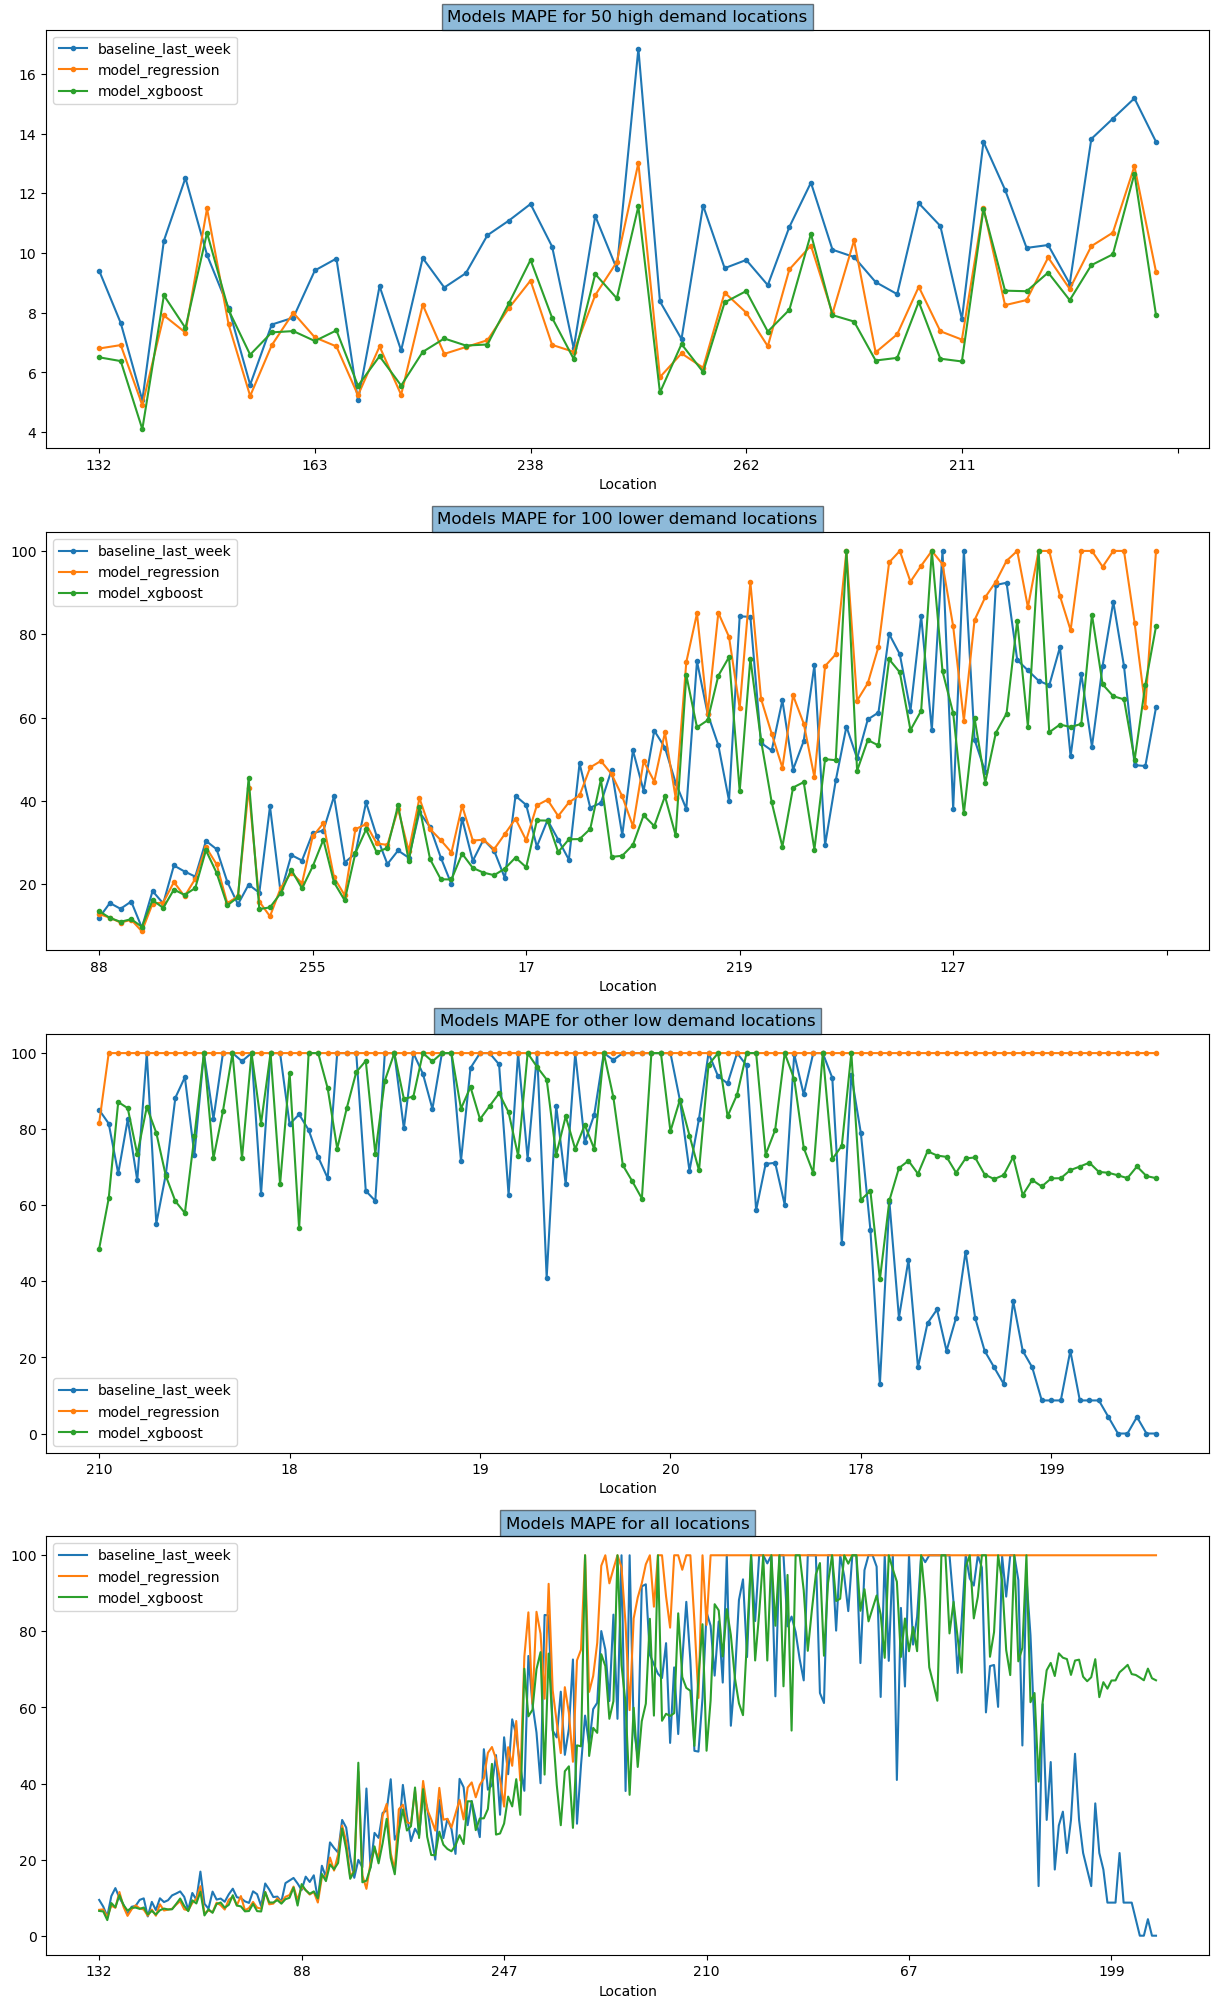

In [86]:
plot_mape(predictions_mean_error_dict, 'Location')

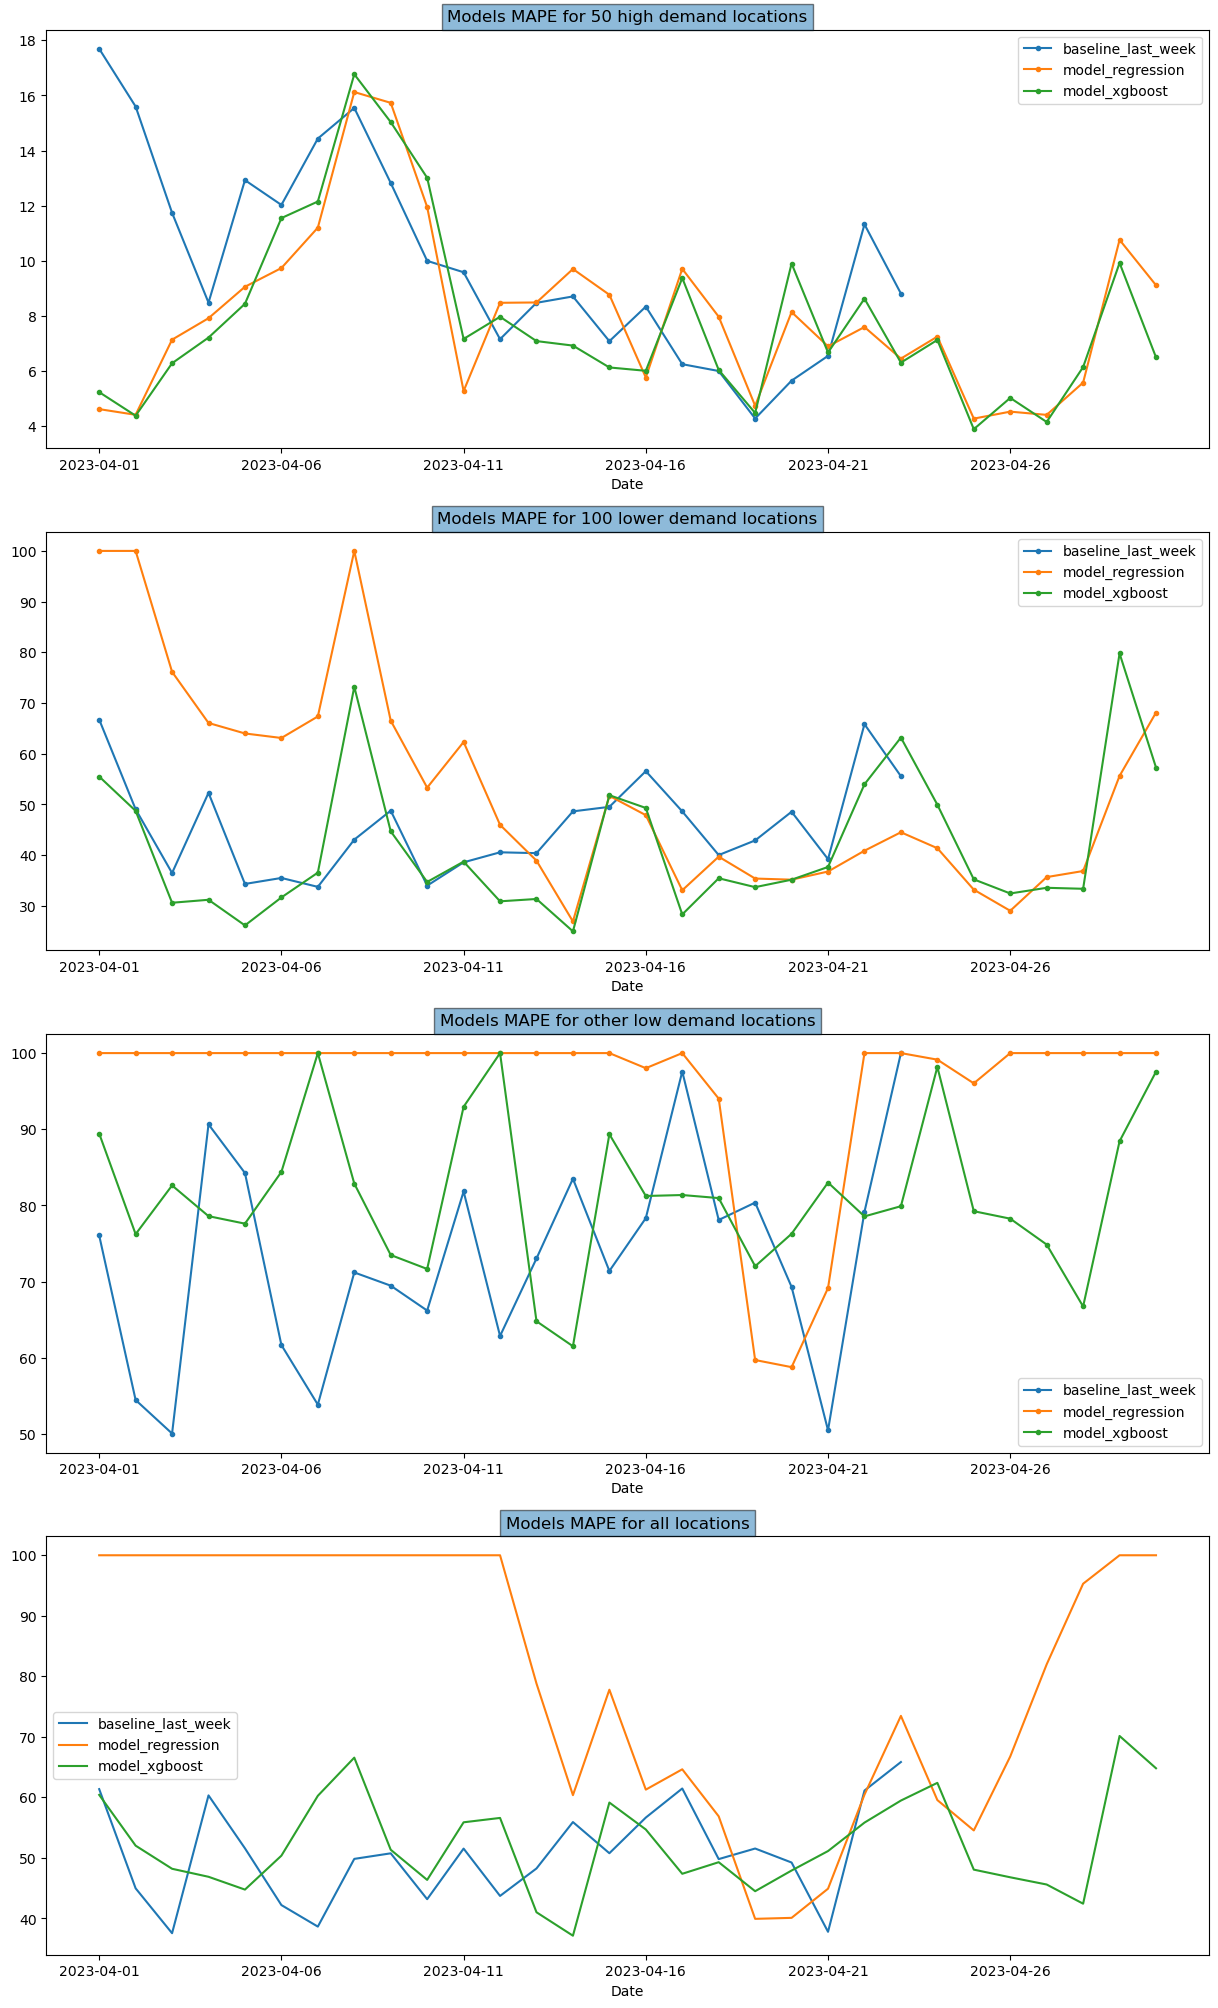

In [87]:
plot_mape(predictions_mean_error_dict, 'Date')

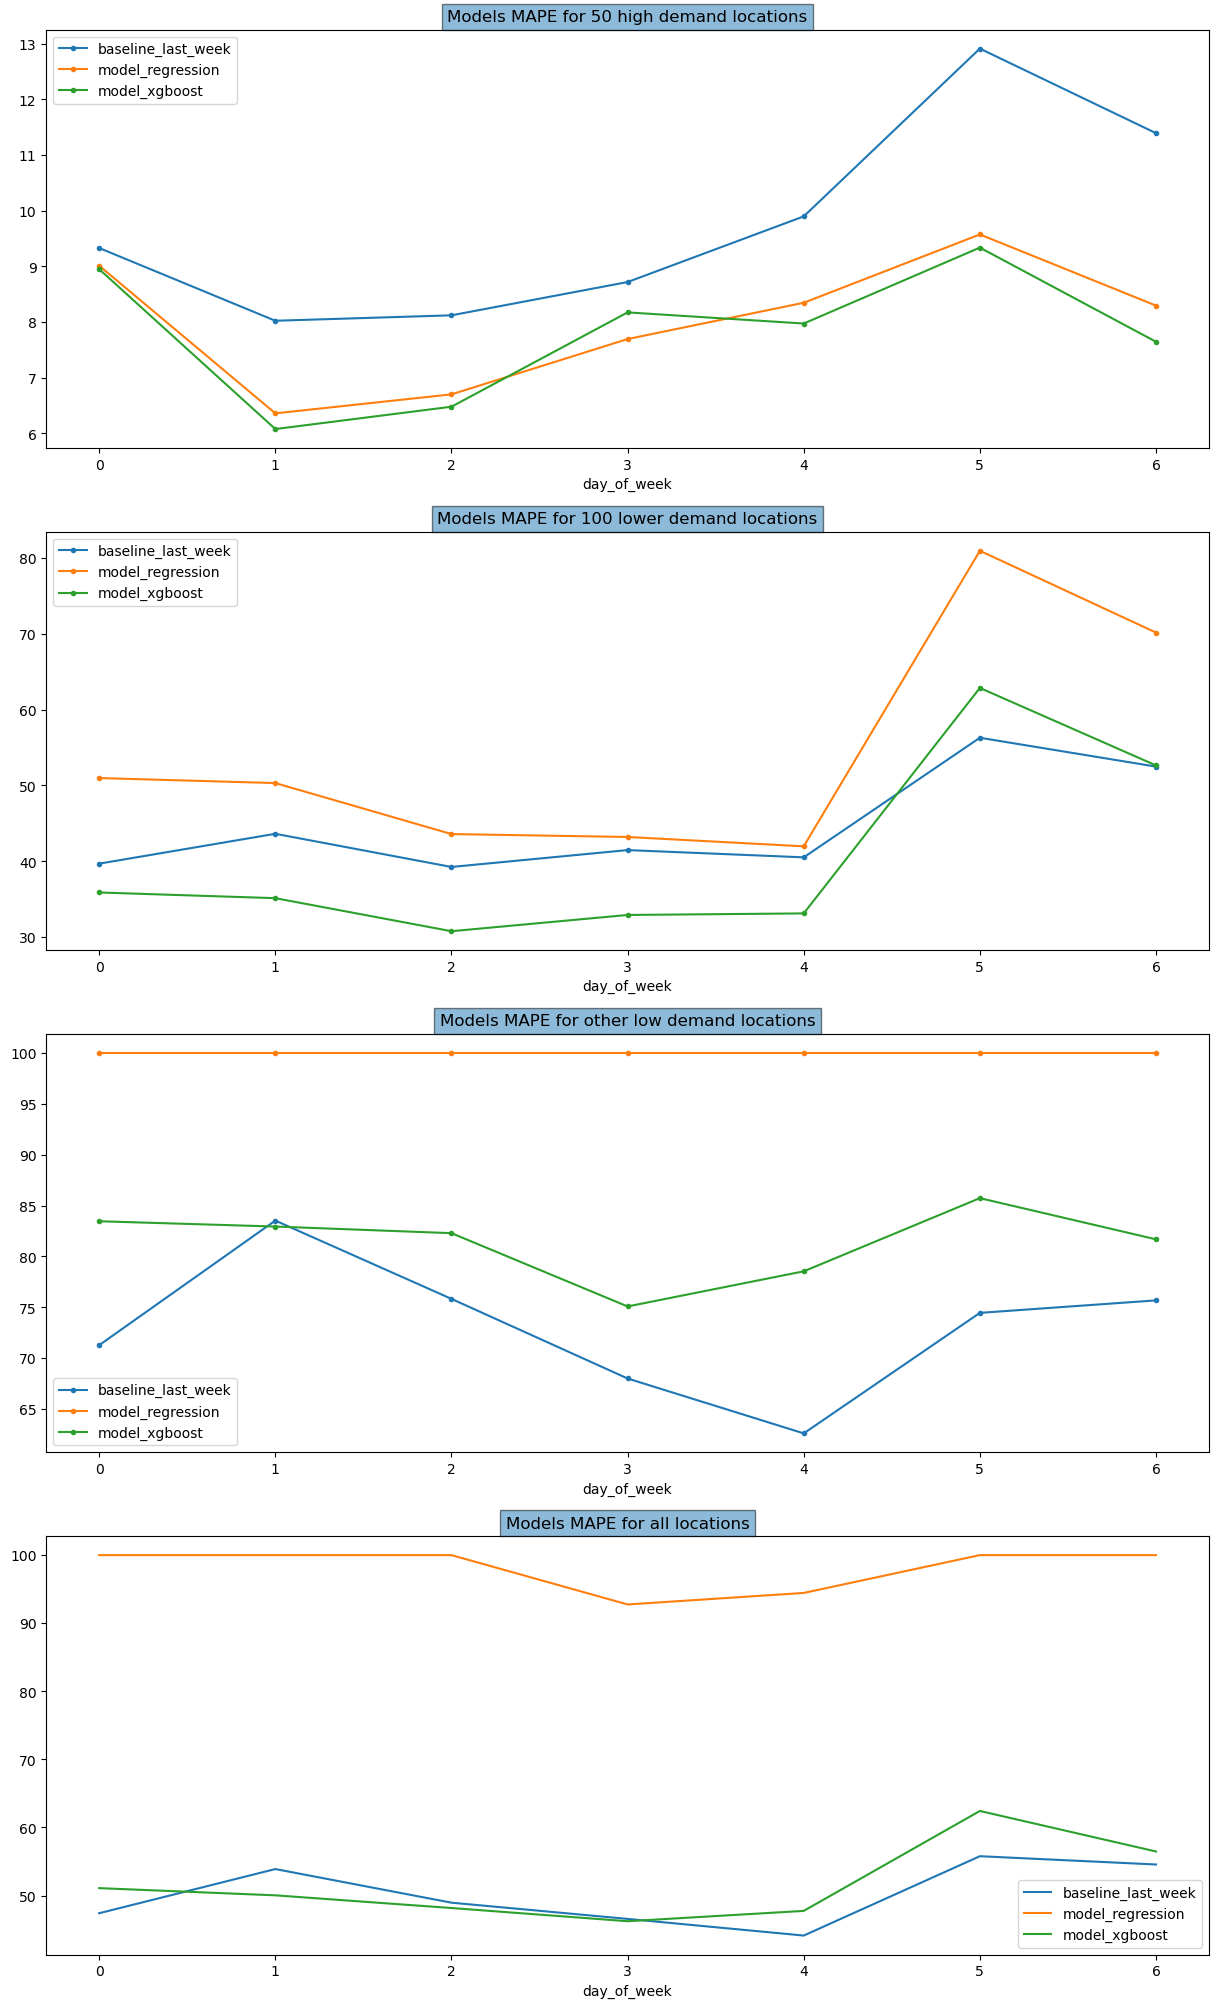

In [88]:
plot_mape(predictions_mean_error_dict, 'day_of_week')

### Plot MAE

In [89]:
def plot_mae(predictions_mean_dict, per):
    
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,25))
    
    for model,mean_df in predictions_mean_dict.items():
        high_demand_df = mean_df[per]['high_demand_loc']
        mid_demand_df = mean_df[per]['mid_demand_loc']
        low_demand_df = mean_df[per]['low_demand_loc']
        all_df = mean_df[per]['all_loc']
        if (low_demand_df is not None) and (mid_demand_df is not None)and (high_demand_df is not None)and (all_df is not None):
            high_demand_df[per] = high_demand_df[per].astype(str)
            mid_demand_df[per] = mid_demand_df[per].astype(str)
            low_demand_df[per] = low_demand_df[per].astype(str)
            all_df[per] = all_df[per].astype(str)

            high_demand_df.plot(x=per,y='mae',kind='line',marker='.',ax = axes[0], label=model)            
            mid_demand_df.plot(x=per,y='mae',kind='line',marker='.',ax = axes[1],label=model)
            low_demand_df.plot(x=per,y='mae',kind='line',marker='.',ax = axes[2],label=model)
            all_df.plot(x=per,y='mae',kind='line',ax = axes[3],label=model)

    axes[0].set_title('Models MAE for '+str(HIGH_DEMAND_NUMS)+' high demand locations', bbox=dict( alpha=0.5)) 
    axes[1].set_title('Models MAE for '+str(MID_DEMAND_NUMS)+' lower demand locations', bbox=dict( alpha=0.5)) 
    axes[2].set_title('Models MAE for other low demand locations', bbox=dict( alpha=0.5)) 
    axes[-1].set_title('Models MAE for all locations', bbox=dict(alpha=0.5))

    plot_name = SAVE_PLOT_PATH + 'ME_plot per '+per+'.svg'
    plt.savefig(plot_name, format='svg', dpi=1200)  


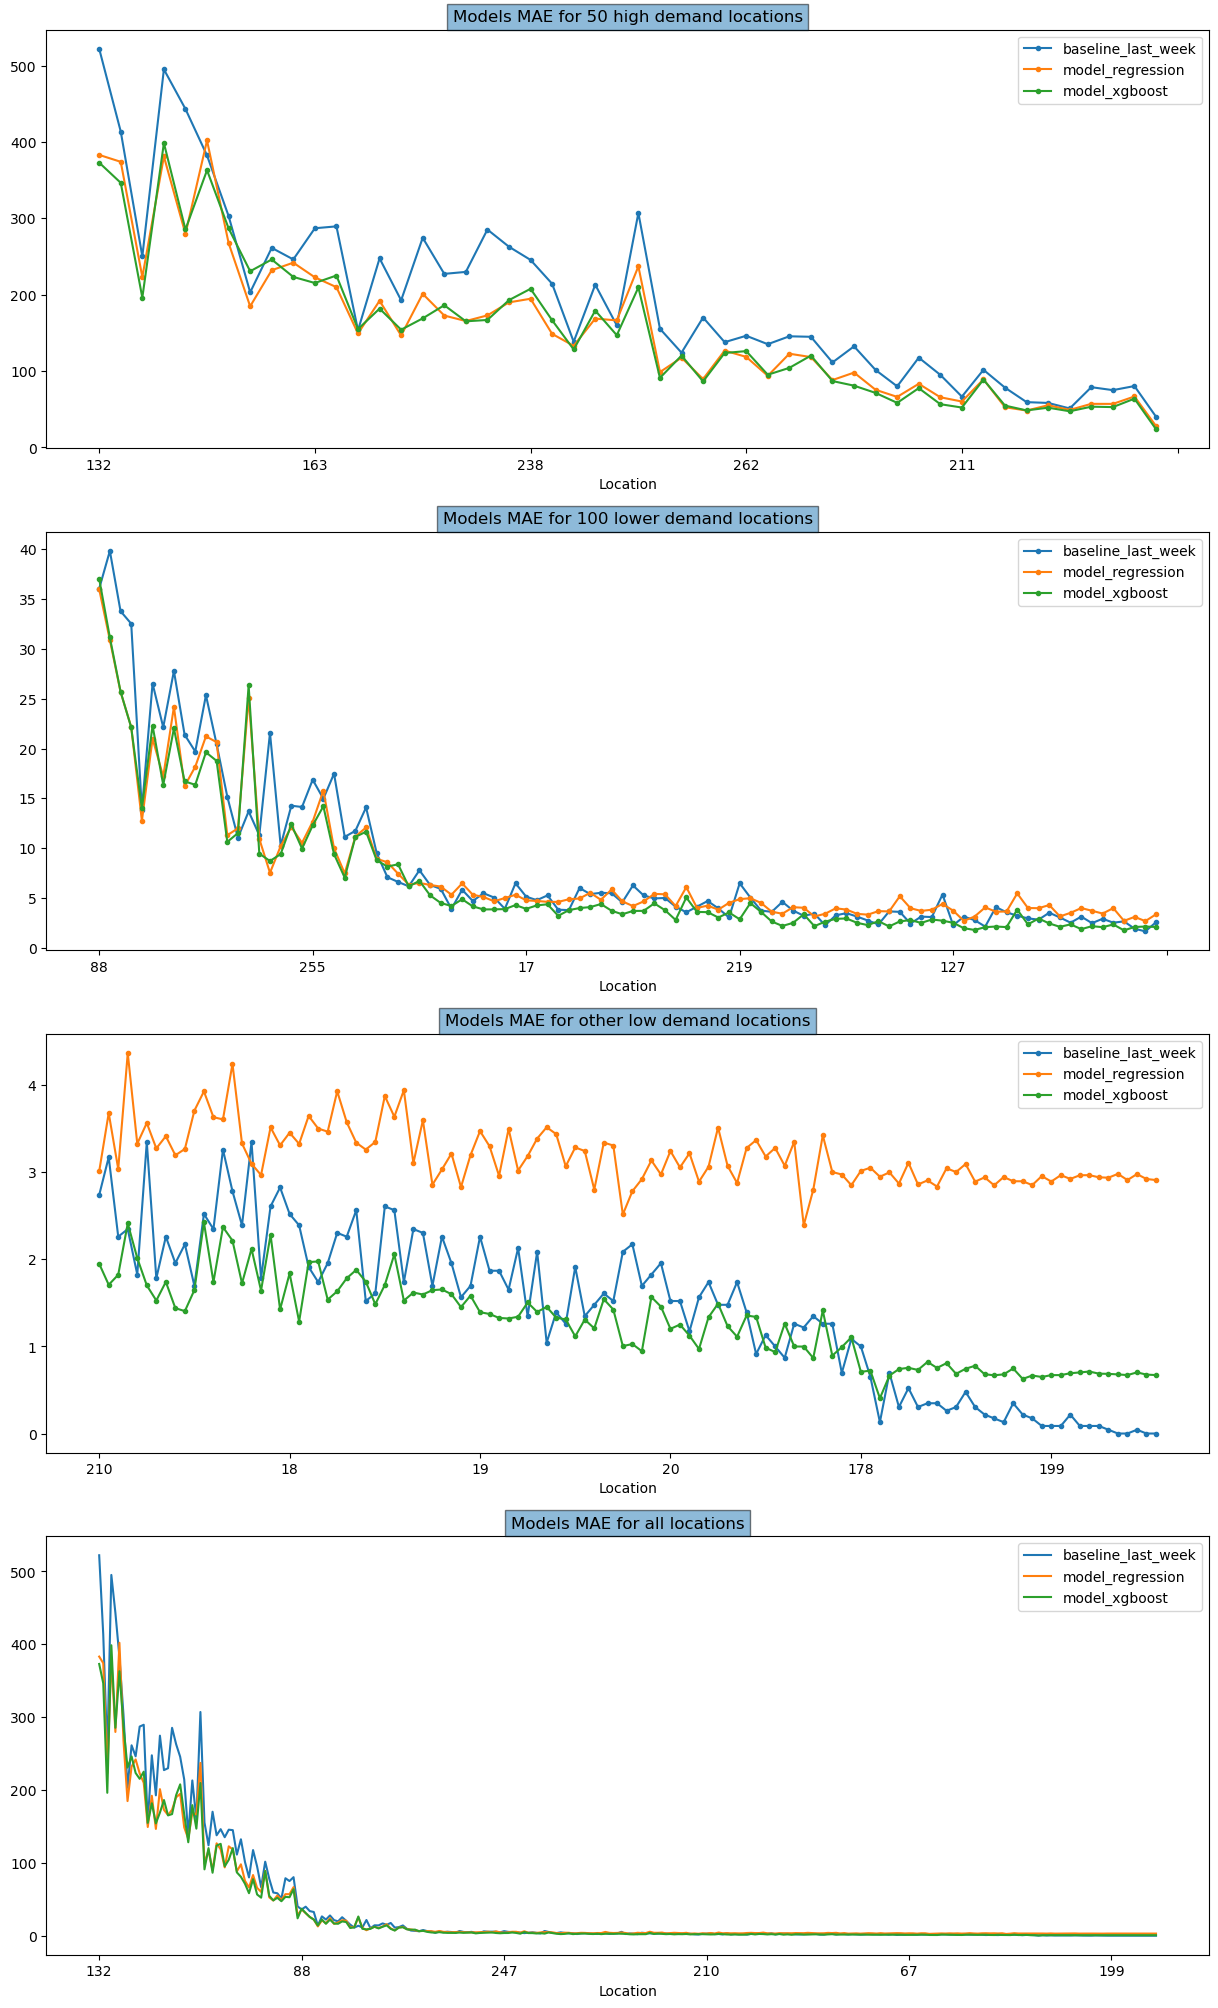

In [90]:
plot_mae(predictions_mean_error_dict, 'Location')

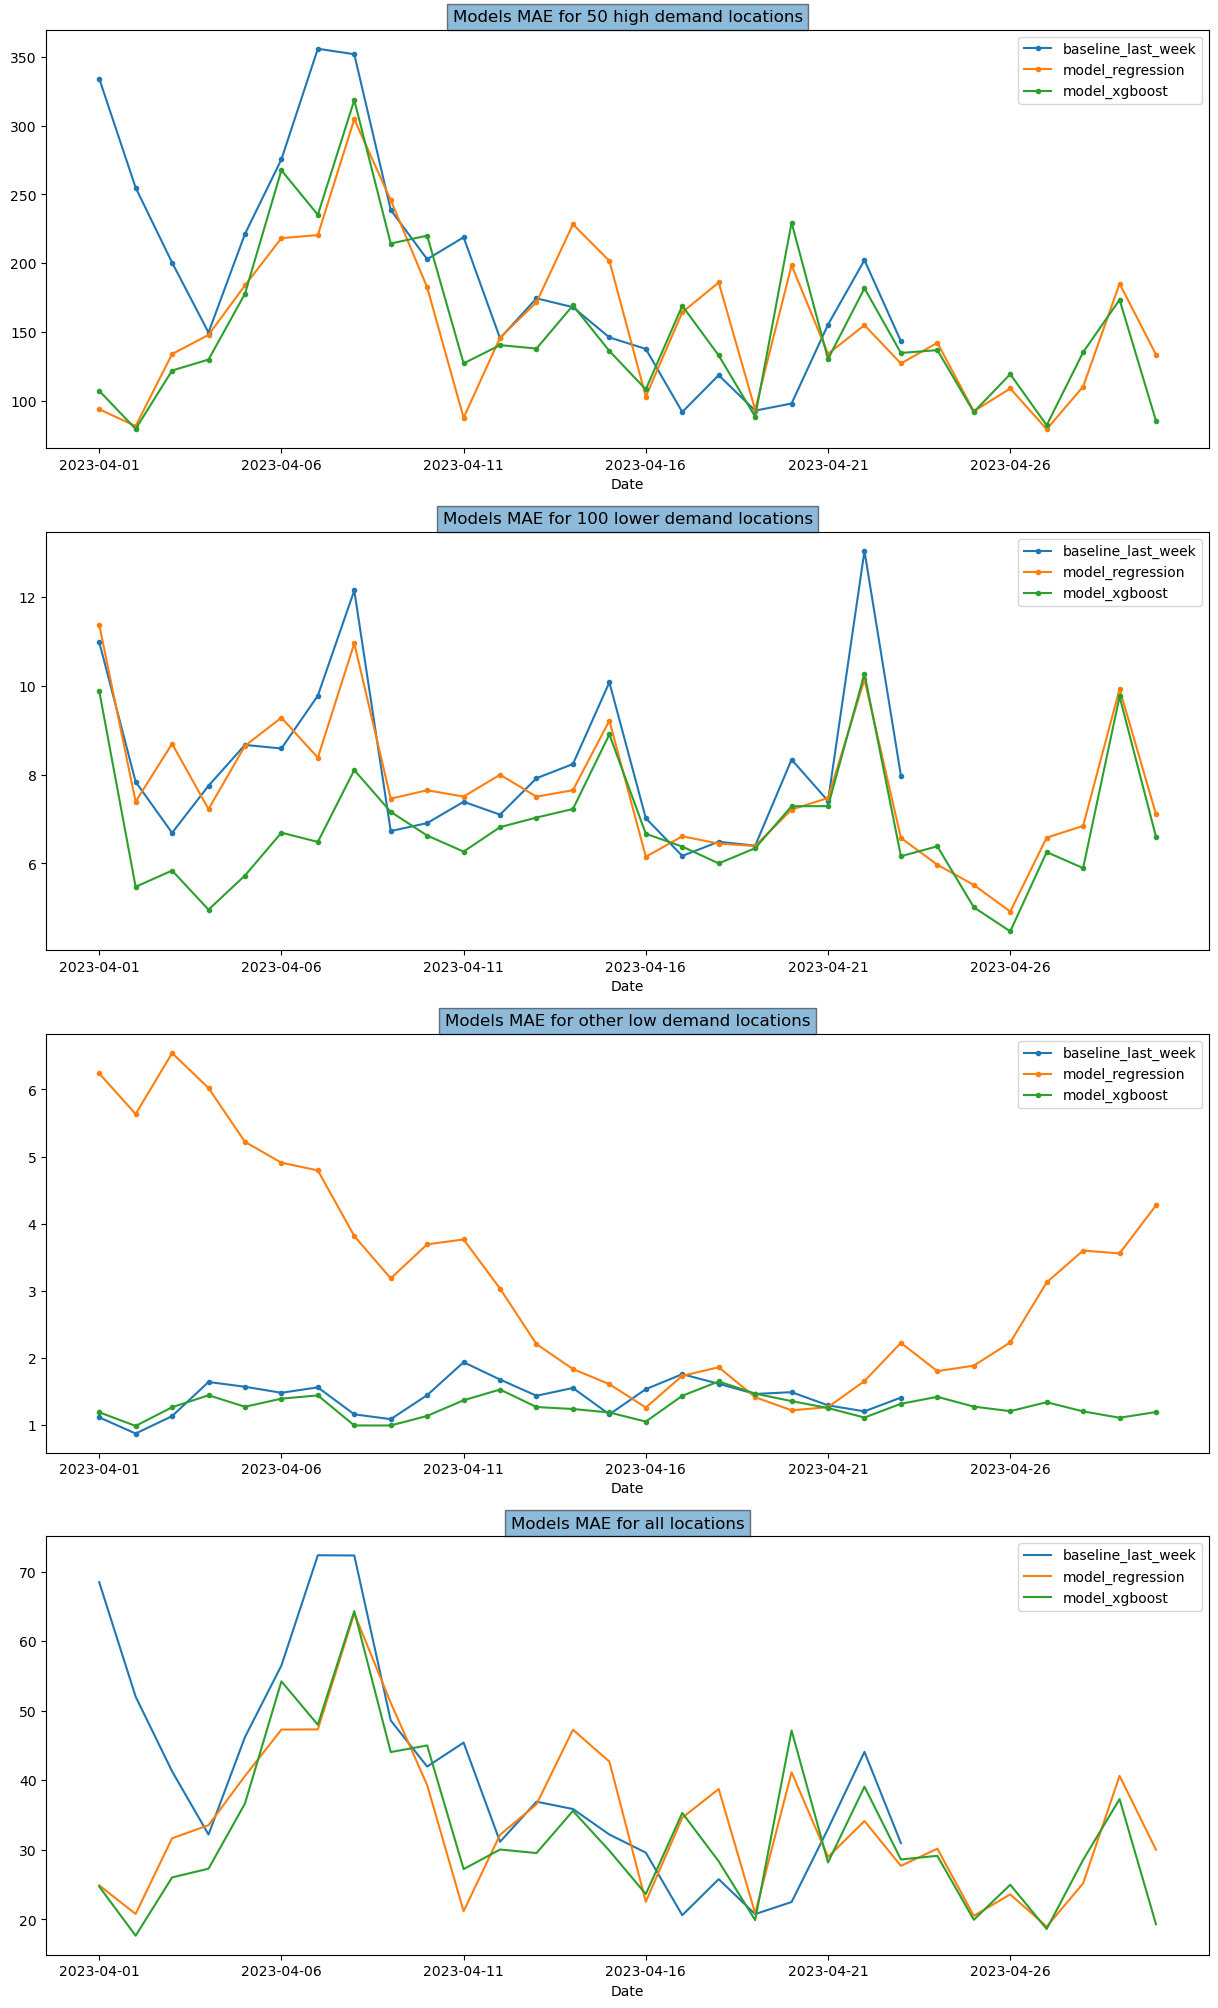

In [91]:
plot_mae(predictions_mean_error_dict, 'Date')

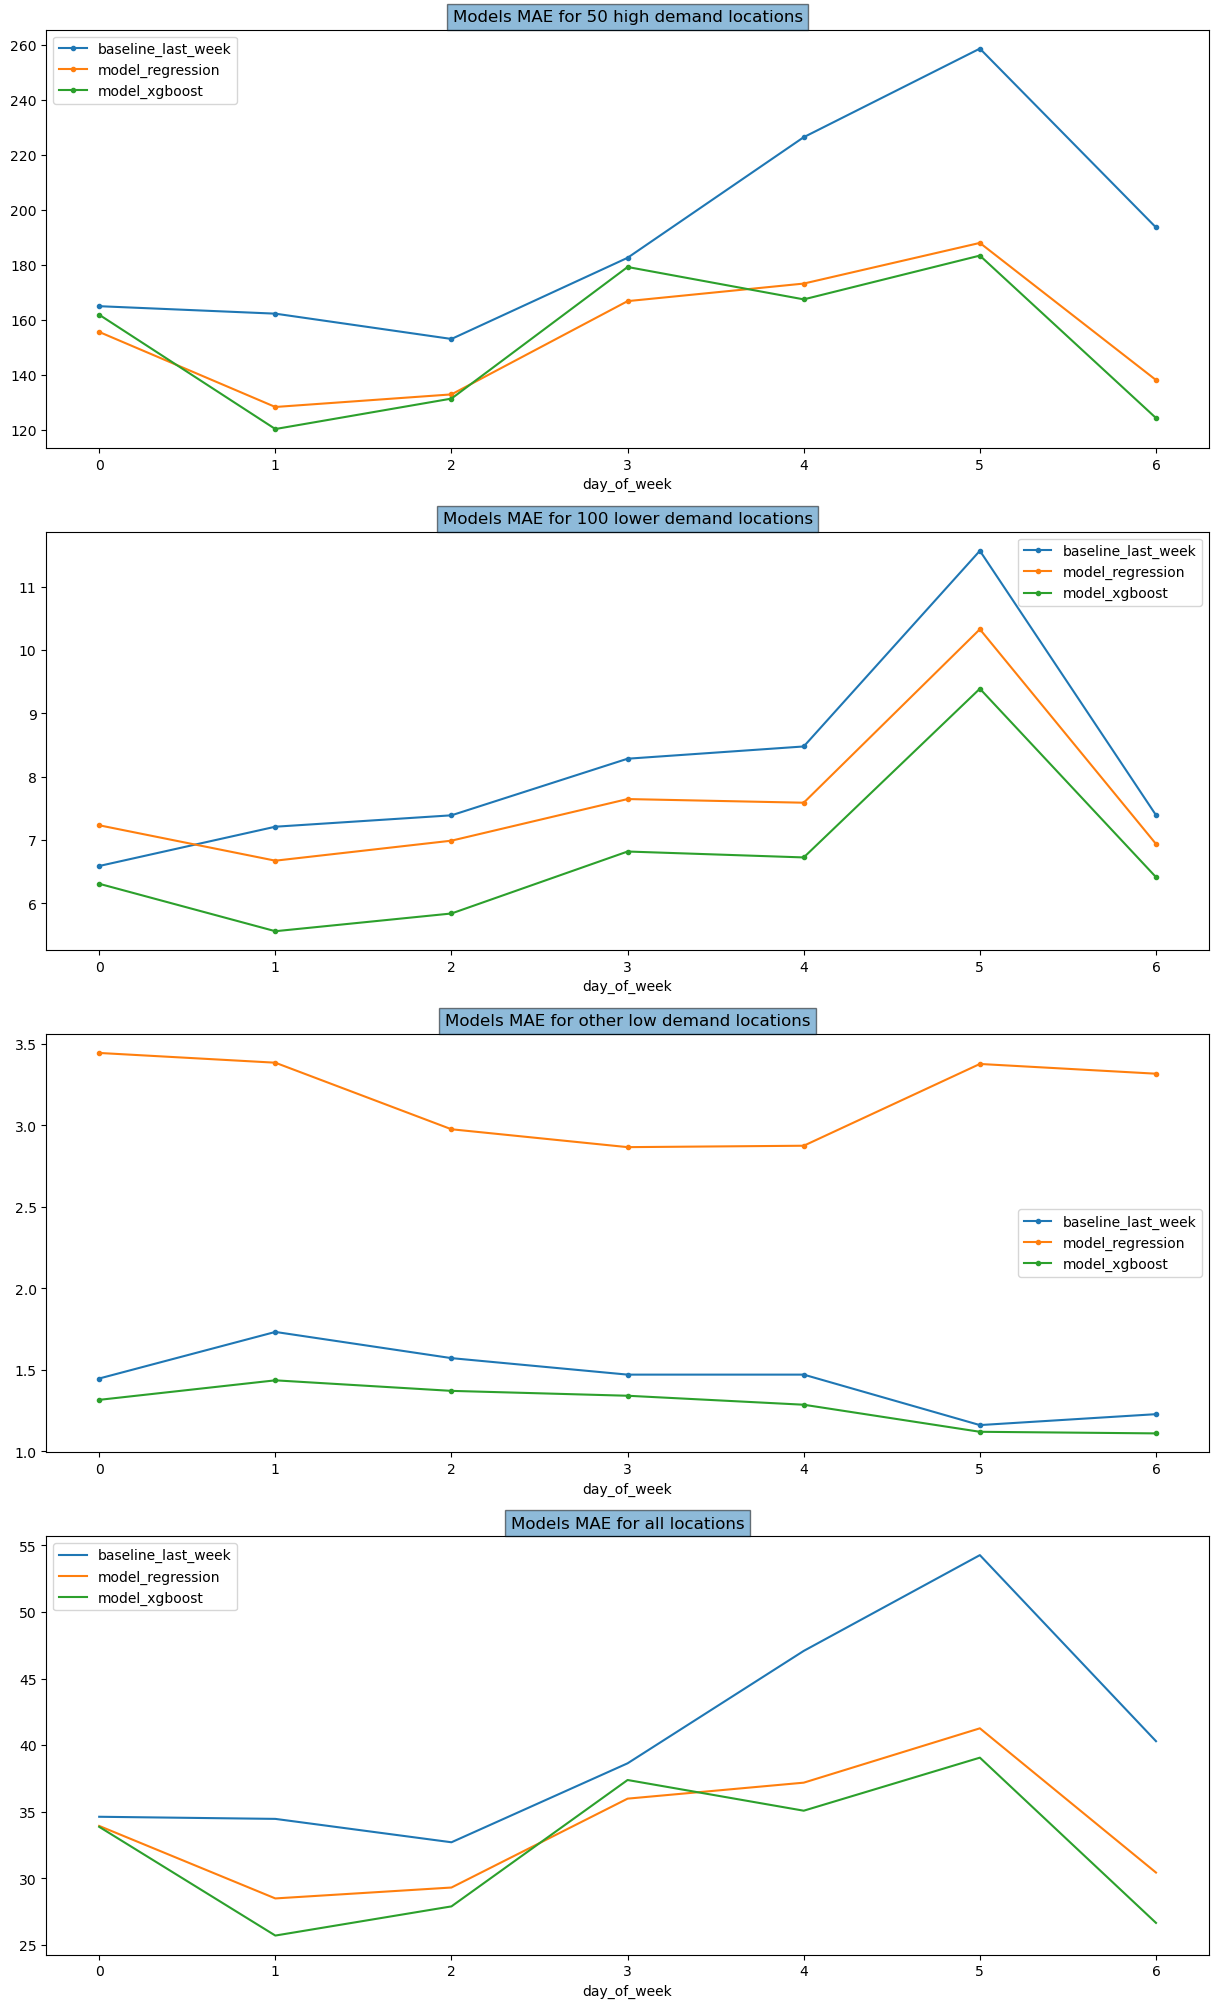

In [92]:
plot_mae(predictions_mean_error_dict, 'day_of_week')

### plot RMSE

In [93]:
def plot_rmse(predictions_mean_dict, per):
    
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,25))
    
    for model,mean_df in predictions_mean_dict.items():
        high_demand_df = mean_df[per]['high_demand_loc']
        mid_demand_df = mean_df[per]['mid_demand_loc']
        low_demand_df = mean_df[per]['low_demand_loc']
        all_df = mean_df[per]['all_loc']
        if (low_demand_df is not None) and (mid_demand_df is not None)and (high_demand_df is not None)and (all_df is not None):
            high_demand_df[per] = high_demand_df[per].astype(str)
            mid_demand_df[per] = mid_demand_df[per].astype(str)
            low_demand_df[per] = low_demand_df[per].astype(str)
            all_df[per] = all_df[per].astype(str)

            high_demand_df['rmse'] = np.sqrt(high_demand_df['mse'])
            mid_demand_df['rmse'] = np.sqrt(mid_demand_df['mse'])
            low_demand_df['rmse'] = np.sqrt(low_demand_df['mse'])
            all_df['rmse'] = np.sqrt(all_df['mse'])

            high_demand_df.plot(x=per,y='rmse',kind='line',marker='.',ax = axes[0], label=model)            
            mid_demand_df.plot(x=per,y='rmse',kind='line',marker='.',ax = axes[1],label=model)
            low_demand_df.plot(x=per,y='rmse',kind='line',marker='.',ax = axes[2],label=model)
            all_df.plot(x=per,y='rmse',kind='line',ax = axes[3],label=model)

    axes[0].set_title('Models RMSE for '+str(HIGH_DEMAND_NUMS)+' high demand locations', bbox=dict( alpha=0.5)) 
    axes[1].set_title('Models RMSE for '+str(MID_DEMAND_NUMS)+' lower demand locations', bbox=dict( alpha=0.5)) 
    axes[2].set_title('Models RMSE for other low demand locations', bbox=dict( alpha=0.5)) 
    axes[-1].set_title('Models RMSE for all locations', bbox=dict(alpha=0.5))

    plot_name = SAVE_PLOT_PATH + 'ME_plot per '+per+'.svg'
    plt.savefig(plot_name, format='svg', dpi=1200)  


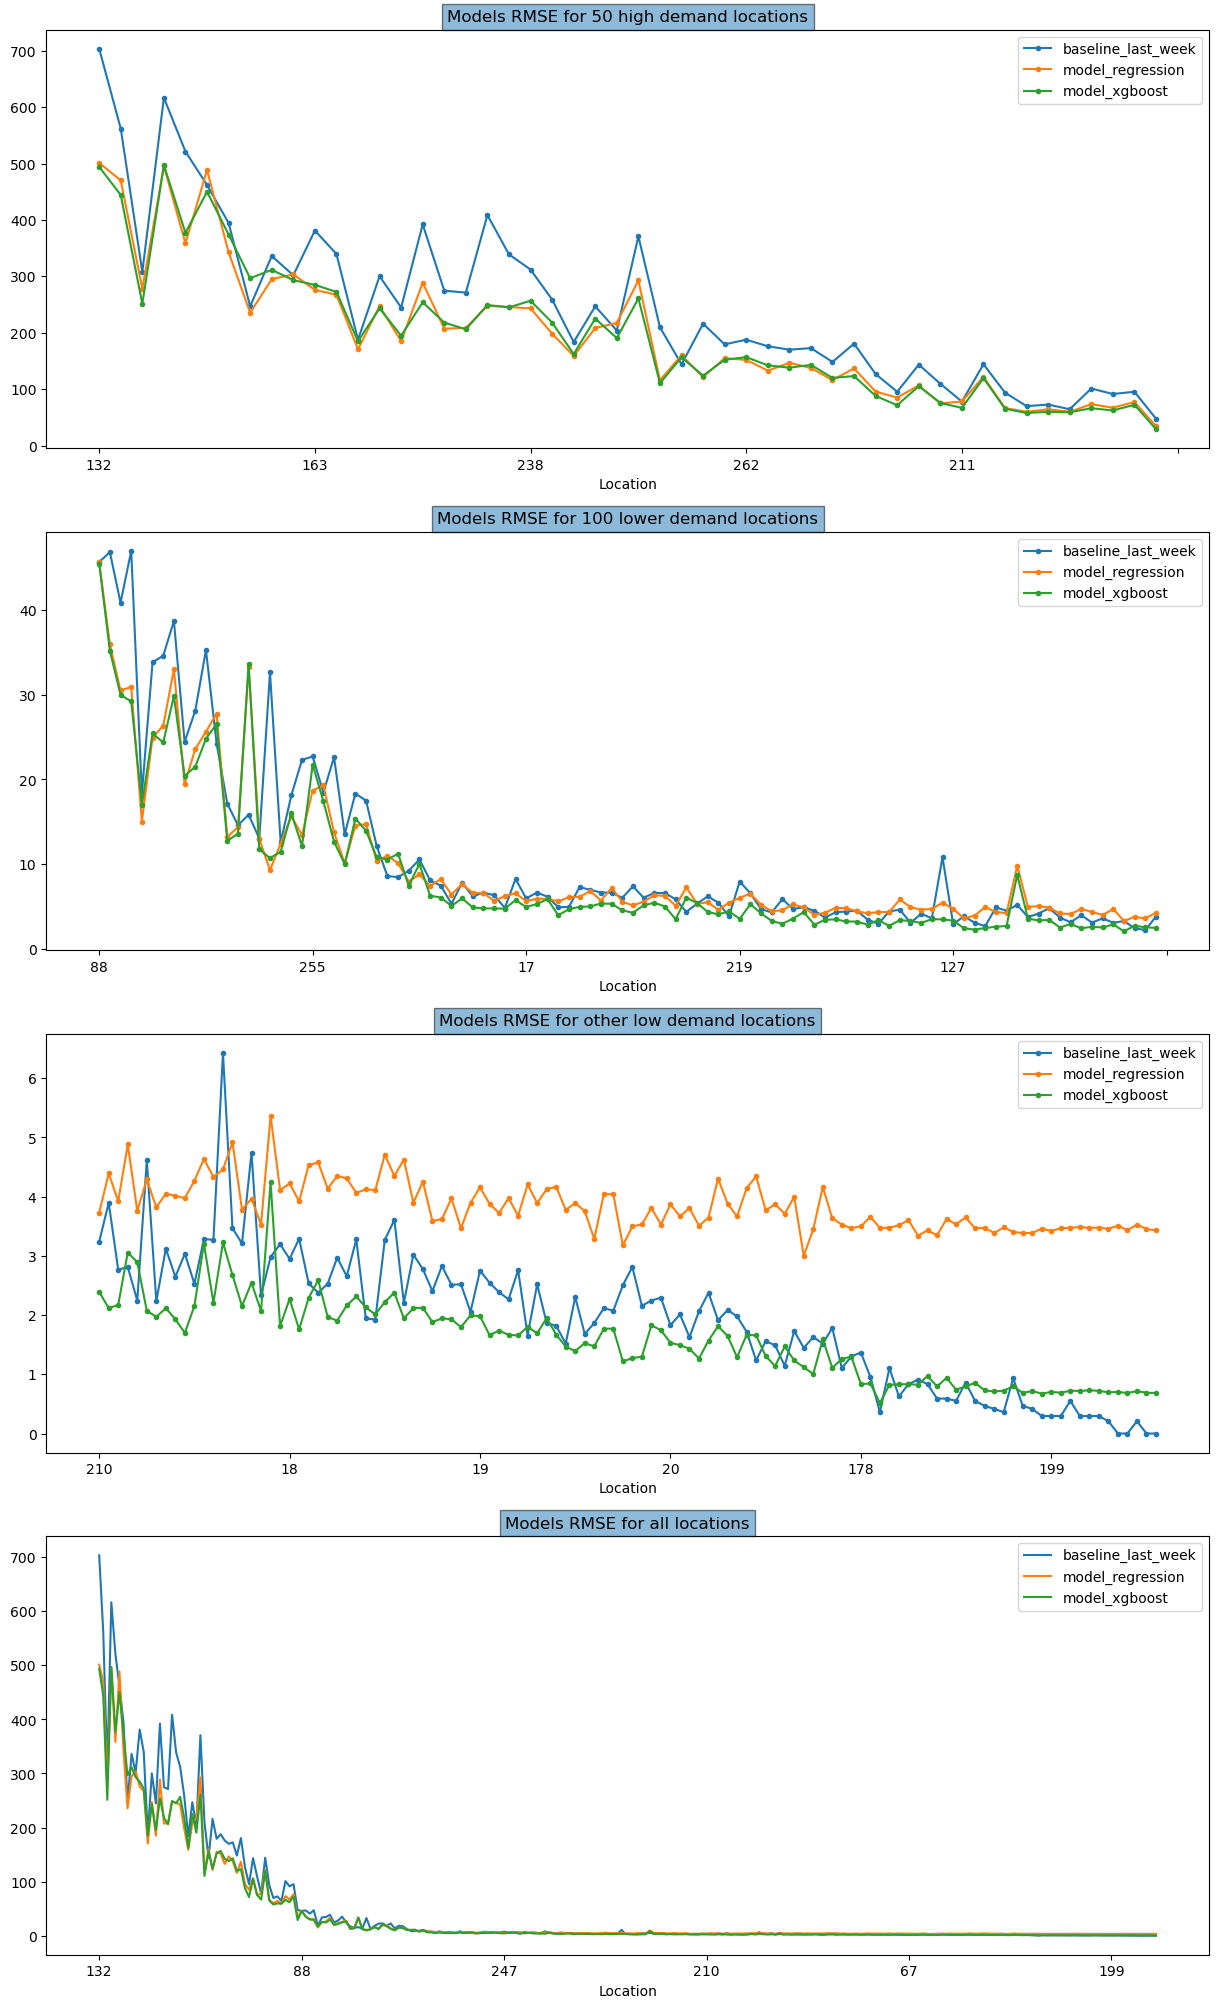

In [94]:
plot_rmse(predictions_mean_error_dict, 'Location')

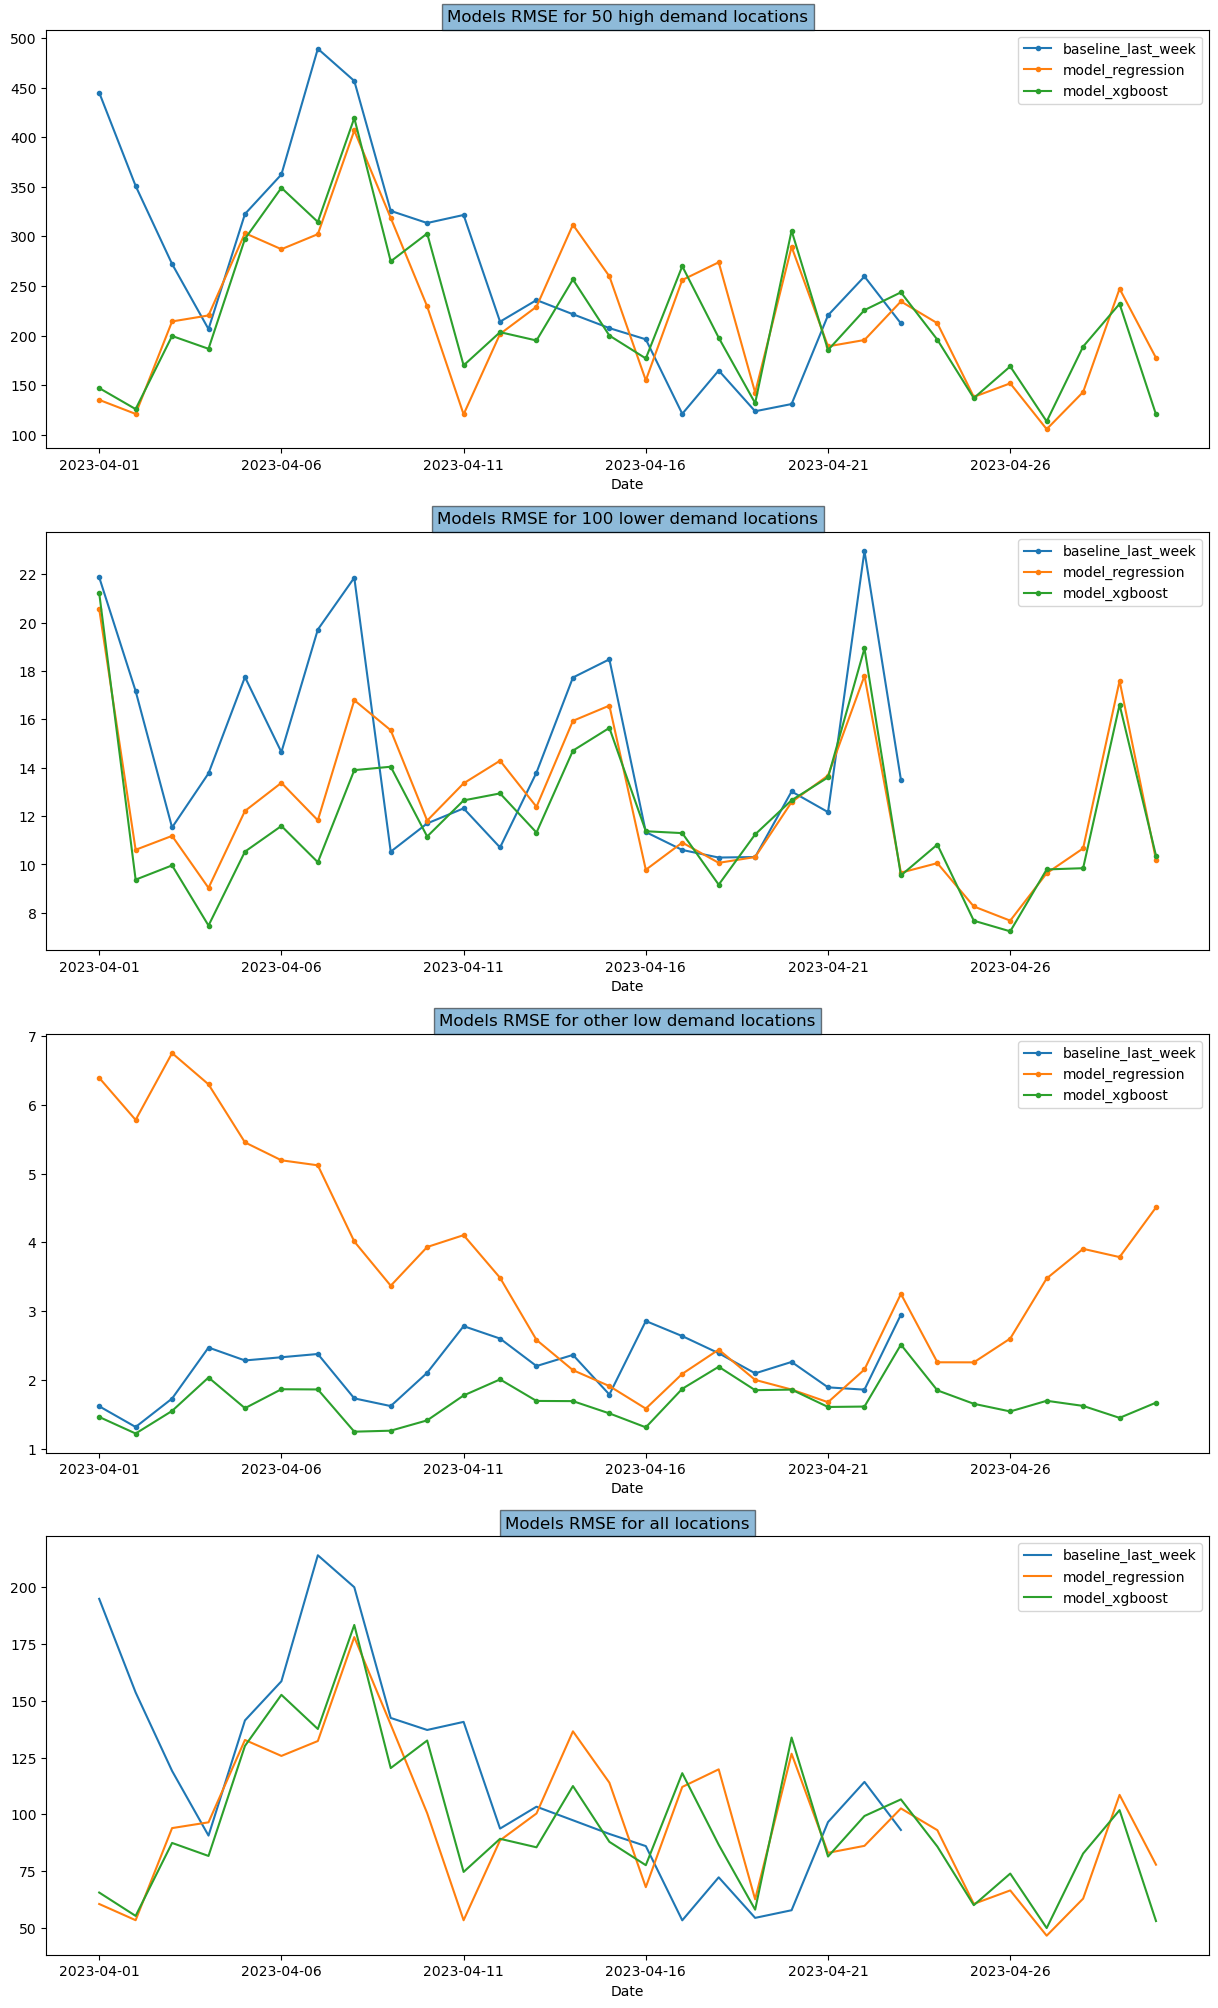

In [95]:
plot_rmse(predictions_mean_error_dict, 'Date')

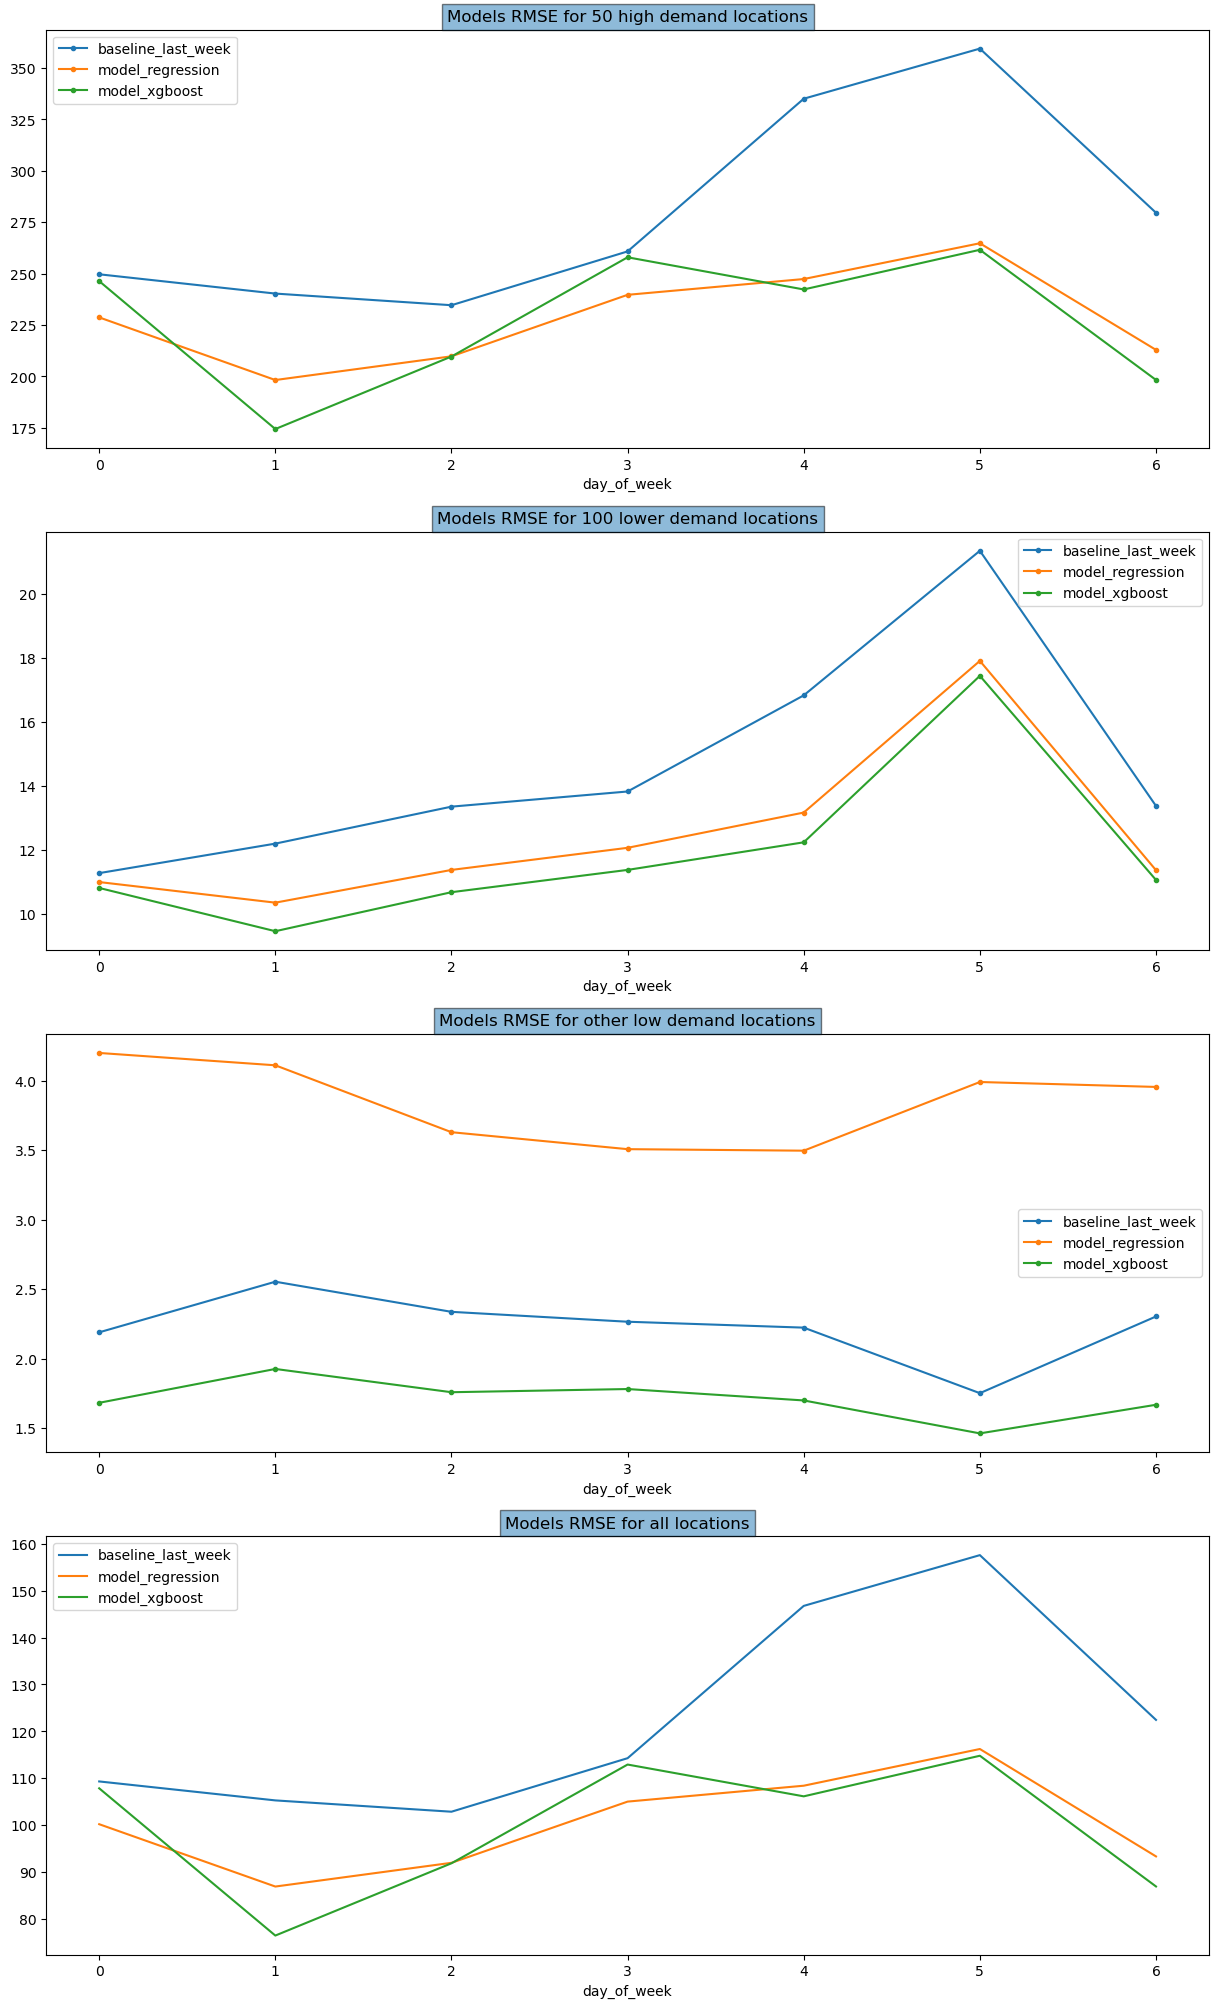

In [96]:
plot_rmse(predictions_mean_error_dict, 'day_of_week')

# Table of Results

In [97]:
def create_table_errors(predictions_dict, report_dict):
    for model, error_df in predictions_dict.items():
        if error_df is not None:
            report_dict['all_locations']['MAE'][model] = error_df['error'].mean()            
            report_dict['all_locations']['RMSE'][model] = np.sqrt(error_df['squared_error'].mean())
            report_dict['all_locations']['MAPE'][model] = error_df['percentage_error'].mean()

            error_high_demand_df = error_df.loc[error_df['Location'].isin(sorted_locations_dict[model][:HIGH_DEMAND_NUMS]['Location'])]
            error_mid_demand_df = error_df.loc[error_df['Location'].isin(sorted_locations_dict[model][HIGH_DEMAND_NUMS:HIGH_DEMAND_NUMS+MID_DEMAND_NUMS]['Location'])]
            error_low_demand_df = error_df.loc[error_df['Location'].isin(sorted_locations_dict[model][HIGH_DEMAND_NUMS+MID_DEMAND_NUMS:]['Location'])]

            report_dict['high_demand_locations']['MAE'][model] = error_high_demand_df['error'].mean()            
            report_dict['high_demand_locations']['RMSE'][model] = np.sqrt(error_high_demand_df['squared_error'].mean())
            report_dict['high_demand_locations']['MAPE'][model] = error_high_demand_df['percentage_error'].mean()
            
            report_dict['mid_demand_locations']['MAE'][model] = error_mid_demand_df['error'].mean()            
            report_dict['mid_demand_locations']['RMSE'][model] = np.sqrt(error_mid_demand_df['squared_error'].mean())
            report_dict['mid_demand_locations']['MAPE'][model] = error_mid_demand_df['percentage_error'].mean()
            
            report_dict['low_demand_locations']['MAE'][model] = error_low_demand_df['error'].mean()            
            report_dict['low_demand_locations']['RMSE'][model] = np.sqrt(error_low_demand_df['squared_error'].mean())
            report_dict['low_demand_locations']['MAPE'][model] = error_low_demand_df['percentage_error'].mean()
    return report_dict

In [102]:
report_dict = create_table_errors(predictions_dict, report_dict)
report_df = pd.DataFrame.from_dict({(i,j): report_dict[i][j] 
                            for i in report_dict.keys() 
                            for j in report_dict[i].keys()},
                            orient='index')

report_df.index = pd.MultiIndex.from_tuples(report_df.index)
report_df = report_df.T

In [99]:
df = pd.DataFrame(report_df,
                  index=pd.Index(['baseline_last_week', 'model_regression', 'model_xgboost']),
                  columns=pd.MultiIndex.from_product([['high_demand_locations', 'mid_demand_locations', 'low_demand_locations', 'all_locations'],
                                                      ['MAPE','MAE','RMSE']], names=['location category:', 'Error Metrics:']))


In [101]:
df.style.format('{:.2f}')